In [1]:
##############
### Import ###
##############

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

from scipy.optimize import curve_fit

import numpy as np
import astropy
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook

In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,rv=3.1):
#     def __init__(self,teff,feh,cnalpha,obsphot,obsphot_err,distance,isochrones,rv=3.1):
        
        '''
        teff: [array] Teff and error of star np.array([teff,teff_err])
        abund: [8x2 array] first column is [Fe/H],[C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe] and
        the second axis is the errors in the first
        obs_phot: [5x2 array] first column is GBP,GRP,J,H,K and the second column is the errors in the first 
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        
        XXXXfeh: [float] metallicity [Fe/H] of star
        XXXXcnalpha: [array] [C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]
        XXXXphot: [array] observed [BP,RP,J,H,K] photometry
        XXXXphot_err: [array] observed [BP,RP,J,H,K] photometry error
        '''
        
        # Observed Quantities
        self.teff = teff[0] # temperature
        self.teff_err = teff[1]
        self.salfeh = self.salariscorrectedfeh(abund[0,0],abund[1:,1]) # Salaris Metallicity
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def salariscorrectedfeh(self,feh,cnalpha):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            salfeh: Salaris corrected metallicity
        '''
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
        # assign solar value to stars if abundance is bad
        for j in range(len(cnalpha)):
            if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                cnalpha[j] = 0.0
                
        if np.isfinite(feh)==False:
            feh = 0.0
        
        # Calculate enhancement factor and corrected metallicity
        fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
        return salfeh 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data):
        '''
        Calculate the median absolute deviation of the data
        '''
        return np.nanmedian(np.abs(data-np.nanmedian(data)))
    
    def ccm_a(self,x):
        '''
        a(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/self.rv
        return alav    
        
    def teff_2_appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def get_age_ak(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                          bounds=((0.,0.),(14.,2.)),method='trf',sigma=self.phot_err,
                                          absolute_sigma=True,maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
#     def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
#         '''
#         Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
#         Inputs:
#         ------
#             best_fit_params: [array]
#             lit_age: [float] optional known literature age in Gyr
#             filename: [str] optional filename of plot if saving
#         '''
        
#         # initialize arrays
#         ages = np.arange(0,15,0.25)
#         theos = 999999.0*np.ones((len(ages),5))
#         theos_noext = 999999.0*np.ones((len(ages),5))
    
#         # calculate theoretical age for given ages
#         for j in range(len(ages)):
#             theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
#             theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
#         # plot results
#         fig, ax = plt.subplots(1,5,figsize=[67,15])
#         for i in range(5):
#             ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
#             ax[i].plot(theos[:,i],ages)
            
#             ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
#             ax[i].plot(theos_noext[:,i],ages)
            
#             ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
#             if lit_age!=None:
#                 ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
#             ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
#             ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
#             ax[i].set_ylim(bottom=0.01)
            
#             ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
#             ax[i].set_xlabel(r'Magnitude')
            
#         ax[0].legend()

#         ax[0].set_ylabel('Age')
        
#         if star_name!=None:
#             plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
#                                                                           best_fit_params[1],self.distance))
        
#         else:
#             plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
#                                                                       self.distance))
    
#         if filename!=None:
#             plt.savefig(filename,bbox_inches='tight')
#         plt.show()
        
    def get_ak(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        nsamples = 100
        ind = np.floor(np.random.random(nsamples)*(nsamples-1)).astype(int)
        lgteffdist = np.log10(np.random.normal(self.teff,self.teff_err,100))[ind]
        
        akdist = 999999.0*np.ones(nsamples)

        ebpk_k = ((self.ccm_alav(self.leff['G_BPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        erpk_k = ((self.ccm_alav(self.leff['G_RPmag'])-self.ccm_alav(self.leff['Ksmag']))/
              self.ccm_alav(self.leff['Ksmag']))
        ejk_k = ((self.ccm_alav(self.leff['Jmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))
        ehk_k = ((self.ccm_alav(self.leff['Hmag'])-self.ccm_alav(self.leff['Ksmag']))/
             self.ccm_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])
        
        for j in range(nsamples):
            # Figure out if age is actually in the ages given in the isochrone table
            if lgage in self.uniq_ages:

                ### pick out a single isochrone 
                aidx, = np.where(self.uniq_ages==lgage)
                iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_['logTe']),max(iso_['logTe'])])

                if lgteffdist[j] < min(iso_['logTe']) or lgteffdist[j] > max(iso_['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing
                sidx = np.argsort(iso_['logTe'])
                slogTe = iso_['logTe'][sidx]
                _, uidx = np.unique(slogTe,return_index=True)
                slogTe = slogTe[uidx]

                ### use a spline to get the intrinsic color and calculate the reddening
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteffdist[j])

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))

                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print(ccm)
                    print(np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)
                akdist[j] = calc_ak

            else:
                lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
                if verbose:
                    print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

                ### Pick out single isochrones

                # younger
                aidx_lo, = np.where(self.uniq_ages==lgage_lo)
                iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

                # older
                aidx_hi, = np.where(self.uniq_ages==lgage_hi)
                iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

                if verbose:
                    print('lgteff, min, max: ',[lgteffdist[j],min(iso_lo['logTe']),max(iso_lo['logTe'])])

                ### Temperature Check
                if lgteffdist[j] < min(iso_lo['logTe']) or lgteffdist[j] > max(iso_lo['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)   
                    akdist[j] = 999999.0
                if lgteffdist[j] < min(iso_hi['logTe']) or lgteffdist[j] > max(iso_hi['logTe']):
                    if verbose:
                        print('Ak: ',999999.0)
                    akdist[j] = 999999.0

                ### sort so temp is always increasing

                # younger
                sidx_lo = np.argsort(iso_lo['logTe'])
                slogTe_lo = iso_lo['logTe'][sidx_lo]
                _, uidx_lo = np.unique(slogTe_lo,return_index=True)
                slogTe_lo = slogTe_lo[uidx_lo]

                # older
                sidx_hi = np.argsort(iso_hi['logTe'])
                slogTe_hi = iso_hi['logTe'][sidx_hi]
                _, uidx_hi = np.unique(slogTe_hi,return_index=True)
                slogTe_hi = slogTe_hi[uidx_hi]

                ### use a spline to get the apparent mags
                age_lo = 10**lgage_lo/10**9
                age_hi = 10**lgage_hi/10**9
                calc_reds = 999999.*np.ones(4)
                for i in range(4):
                    color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                    color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                    age_spl_interp = np.poly1d(np.squeeze(
                        np.polyfit([age_lo,age_hi],[color_spl_lo(lgteffdist[j]),color_spl_hi(lgteffdist[j])],1)))
                    if verbose:
                        print('interp',age_spl_interp)
                        print('logteff',lgteffdist[j])
                        print('interp age',age_spl_interp(lgteffdist[j]))
                        print('color',self.phot[i]-self.phot[4])
                    calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

                ### calculate the Ak value
                calc_ak = np.median(np.divide(calc_reds,ccm))
                if verbose:
                    print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                    print('CCM: ',ccm)
                    print('Ak each band',np.divide(calc_reds,ccm))
                    print('Calc Ak: ',calc_ak)

#                 print(calc_ak)
                akdist[j] = calc_ak
            
#         print(akdist)
        med_calc_ak = np.nanmedian(akdist)
        mad_calc_ak = self.mad(akdist)
        
        if np.isfinite(med_calc_ak)==False:
            med_calc_ak = 999999.0
        if np.isfinite(mad_calc_ak)==False:
            mad_calc_ak = 999999.0
        
        self.ak = med_calc_ak
        self.ak_err = mad_calc_ak
        
        return np.array([med_calc_ak,mad_calc_ak])

    def teff_2_appmags_age(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.ccm_alav(self.leff['G_BPmag'])/self.ccm_alav(self.leff['Ksmag'])
        arpak = self.ccm_alav(self.leff['G_RPmag'])/self.ccm_alav(self.leff['Ksmag'])
        ajak = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])
        ahak = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
        
    def get_age(self,guess_ages=np.arange(0,14),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_ages_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags_age,self.teff,self.phot,p0=guess_ages[j],
                                      bounds=(0.,14.),method='trf',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_ages_err.append(np.sqrt(pcov[0][0]))
                curve_mags = np.asarray(self.teff_2_appmags_age(self.teff,popt[0]))
                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

            except:
                #populate lists
                curve_ages.append(999999.0)
                curve_ages_err.append(999999.0)
                curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        age_err = np.asarray(curve_ages_err)[idx]

        best_params = np.array([age,age_err])
#         best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff_2_appmags_age(self.teff,age)#,ak)

        if verbose:
            print('Best Fit Params [Age, Age Err]:',np.round(best_params,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params

# Cardelli Extinction

In [4]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

In [5]:
abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [8]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Globular Clusters

In [9]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz')
gcs = Table(gcs[np.where((gcs['LOGG']>0.0)&(gcs['FE_H']>-9999.0)&(np.isfinite(gcs['FE_H'])==True))])
gcs = gcs[np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                   (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M15')|
                   (gcs['CLUSTER']=='M19')|(gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|
                   (gcs['CLUSTER']=='M3')|(gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|
                   (gcs['CLUSTER']=='M53')|(gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|
                   (gcs['CLUSTER']=='M68')|(gcs['CLUSTER']=='M71')|(gcs['CLUSTER']=='M79')|
                   (gcs['CLUSTER']=='M92')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                   (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                   (gcs['CLUSTER']=='NGC5053')|(gcs['CLUSTER']=='NGC5466')|(gcs['CLUSTER']=='NGC6304')|
                   (gcs['CLUSTER']=='NGC6388')|(gcs['CLUSTER']=='NGC6752')|(gcs['CLUSTER']=='NGC6760'))]

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, gcs_ind, dr17_ind = np.intersect1d(gcs['APOGEE_ID'], dr17['APOGEE_ID'], return_indices=True)

gcsdr17 = dr17[dr17_ind]
gcs = gcs[gcs_ind]

gcs_clus = np.unique(gcs['CLUSTER'])

Harris-APOGEE: -0.07535000324249275
VandenBerg-APOGEE: -0.08275001049041741
Overall: -0.07905000686645508


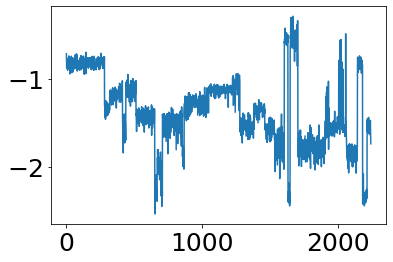

In [10]:
med_apo_feh = np.array([])
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcsdr17['FE_H']>-100.))
    med_apo_feh = np.append(med_apo_feh,np.nanmedian(gcsdr17['FE_H'][clus]))
#     print('{}: {:.3f}'.format(gcs_clus[i],np.nanmedian(gcsdr17['FE_H'][clus])))
    
harris_dist = np.array([4.5,4.4,6.3,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,
                        9.6,8.9,4.9,8.6,17.4,16.0,5.9,9.9,4.0,7.4])*1000
harris_feh = np.array([-0.72,-1.56,-1.02,-1.37,-1.53,-2.37,-1.74,-1.65,-1.70,-1.50,-1.16,-1.29,-2.10,-1.49,-1.94,
                       -2.23,-0.78,-1.60,-2.31,-1.18,-1.14,-1.32,-1.59,-1.26,-2.27,-1.98,-0.45,-0.55,-1.54,-0.40])
harris_ext = np.array([0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.06,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,
                       0.02,0.02,0.22,0.03,0.24,0.05,0.01,0.00,0.54,0.37,0.04,0.77])
vanden_feh = np.array([-0.76,-1.57,-1.03,-1.33,-1.58,-2.33,-1.53,-1.66,-1.70,-1.50,-1.18,-1.33,-2.06,-1.44,-1.93,
                       -2.27,-0.82,-1.60,-2.35,-1.18,-1.18,-1.32,-1.51,-1.30,-2.30,-2.31,-0.37,-0.77,-1.55,-0.60])
vanden_age = np.array([11.75,11.75,12.00,13.00,12.00,12.75,11.90,11.75,12.50,11.75,11.50,11.50,12.25,11.75,13.00,
                       12.00,11.00,11.0,12.75,11.00,11.00,11.50,11.50,11.75,12.25,12.50,11.25,12.03,12.50,11.26])

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris_dist[i]
#     print(clus)

print('Harris-APOGEE:',np.median(harris_feh-med_apo_feh))
print('VandenBerg-APOGEE:',np.median(vanden_feh-med_apo_feh))
print('Overall:',np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))

shiftfeh = 999999*np.ones(len(gcsdr17))
for i in range(len(gcsdr17)):
    clus = np.where(gcs['CLUSTER']==gcs['CLUSTER'][i])
    if np.isfinite(gcsdr17['FE_H'][i])==False:
        shiftfeh[i] = (np.median(gcsdr17['FE_H'][clus])+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
    else:
        shiftfeh[i] = (gcsdr17['FE_H'][i]+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
        
plt.plot(shiftfeh)

In [11]:
def salaris(feh,cnalpha):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
    Output:
    ------
            
    '''
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
    # assign solar value to stars if abundance is bad
    for j in range(len(cnalpha)):
        if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
            cnalpha[j] = 0.0
        
    if np.isfinite(feh)==False:
        feh = 0.0
    
    fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
    salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
    return salfeh

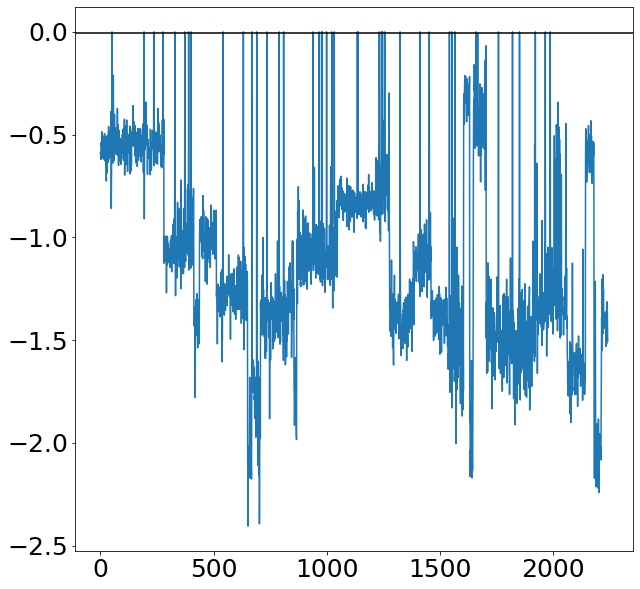

In [12]:
all_sal_feh = np.array([])
for i in range(len(gcsdr17)):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
#     all_sal_feh = np.append(all_sal_feh,salaris(gcsdr17['FE_H'][i],cnalpha))
    all_sal_feh = np.append(all_sal_feh,salaris(shiftfeh[i],cnalpha))
    
plt.figure(figsize=[10,10])
plt.plot(all_sal_feh)
plt.axhline(-0.005,c='k')

In [13]:
### VandenBerg et al. Salaris corrected [Fe/H]

vanfeh = 999999.0*np.ones(len(gcsdr17))

for i in range(len(gcs_clus)):
    clus = np.where(gcs['CLUSTER']==gcs_clus[i])
    vanfeh[clus] = vanden_feh[i]
    
salvanfeh = 999999.0*np.ones(len(vanden_feh))
for i in tqdm_notebook(range(len(gcs_clus))):
    clus = np.where(gcs['CLUSTER']==gcs_clus[i])
    clusfeh = []
    for j in tqdm_notebook(range(len(np.squeeze(clus))),leave=False):
        cnalpha = np.array([gcsdr17[clus]['C_FE'][j],gcsdr17[clus]['N_FE'][j],gcsdr17[clus]['O_FE'][j],
                            gcsdr17[clus]['MG_FE'][j],gcsdr17[clus]['SI_FE'][j],gcsdr17[clus]['S_FE'][j],
                            gcsdr17[clus]['CA_FE'][j],gcsdr17[clus]['TI_FE'][j]])
        
        clusfeh.append(salaris(vanden_feh[i],cnalpha))
        
    salvanfeh[i] = np.nanmedian(clusfeh)

print(salvanfeh)


[-0.49629611 -1.37258468 -0.72299536 -1.08793535 -1.42216128 -2.02963541
 -1.32601745 -1.51373837 -1.44001048 -1.37642037 -0.8821581  -1.13907402
 -1.84903555 -1.32598783 -1.72810988 -2.08272616 -0.57838252 -1.4564343
 -2.04507515 -1.00381372 -1.04205799 -1.0504233  -1.3608809  -1.16872294
 -2.09491288 -2.24582809 -0.13164551 -0.63529077 -1.34861413 -0.35580541]


# Gaia Errors

In [14]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

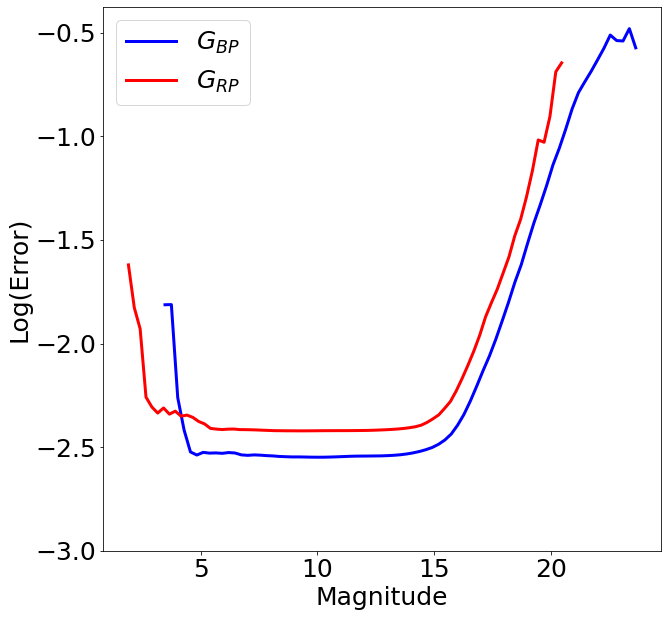

In [15]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

In [16]:
bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# NGC3201 Offsets

In [50]:
gcs_ext = 999999.0*np.ones(len(gcsdr17))
gcs_dist = 999999.0*np.ones(len(gcsdr17))
for i in range(len(harris_ext)):
    clus = np.where(gcs['CLUSTER']==gcs_clus[i])
    gcs_ext[clus] = harris_ext[i]
    gcs_dist[clus] = harris_dist[i]

In [18]:
# ### testaks
# for i in range(len(gcsdr17[np.where(gcs['CLUSTER']=='M22')])):
    
    
    
#     print(i)

In [52]:
ngc3201idx = np.where(gcs['CLUSTER']=='NGC3201')

bf_ext = 999999.0*np.ones((len(np.squeeze(ngc3201idx)),2))
bf_age = 999999.0*np.ones((len(np.squeeze(ngc3201idx)),2))

for i in tqdm_notebook(range(len(np.squeeze(ngc3201idx)))):
    
    teff = np.array([gcsdr17['TEFF'][ngc3201idx][i],gcsdr17['TEFF_ERR'][ngc3201idx][i]])
    
    abund = np.array([[gcsdr17['FE_H'][ngc3201idx][i],gcsdr17['C_FE'][ngc3201idx][i],gcsdr17['N_FE'][ngc3201idx][i],
                       gcsdr17['O_FE'][ngc3201idx][i],gcsdr17['MG_FE'][ngc3201idx][i],gcsdr17['SI_FE'][ngc3201idx][i],
                       gcsdr17['S_FE'][ngc3201idx][i],gcsdr17['CA_FE'][ngc3201idx][i],gcsdr17['TI_FE'][ngc3201idx][i]],
                      [gcsdr17['FE_H_ERR'][ngc3201idx][i],gcsdr17['C_FE_ERR'][ngc3201idx][i],gcsdr17['N_FE_ERR'][ngc3201idx][i],
                       gcsdr17['O_FE_ERR'][ngc3201idx][i],gcsdr17['MG_FE_ERR'][ngc3201idx][i],gcsdr17['SI_FE_ERR'][ngc3201idx][i],
                       gcsdr17['S_FE_ERR'][ngc3201idx][i],gcsdr17['CA_FE_ERR'][ngc3201idx][i],gcsdr17['TI_FE_ERR'][ngc3201idx][i]]]).T
    
    
    obsphot = np.array([[gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][ngc3201idx][i],gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][ngc3201idx][i],gcsdr17['J'][ngc3201idx][i],gcsdr17['H'][ngc3201idx][i],gcsdr17['K'][ngc3201idx][i]],
                        [bperr[ngc3201idx][i],rperr[ngc3201idx][i],gcsdr17['J_ERR'][ngc3201idx][i],gcsdr17['H_ERR'][ngc3201idx][i],gcsdr17['K_ERR'][ngc3201idx][i]]]).T
    
    CalcAge = Aetas(teff,abund,obsphot,4900,massive)
    
    best_fit_ext = CalcAge.get_ak(12.5)
    best_fit_age = CalcAge.get_age()
    
    bf_ext[i,0] = best_fit_ext[0]
    bf_ext[i,1] = best_fit_ext[1]
    bf_age[i,0] = best_fit_age[0]
    bf_age[i,1] = best_fit_age[1]
    
    #get_age(self,guess_ages=np.arange(0,14),verbose=False)

0.09076502277040627
0.0015012168174967366


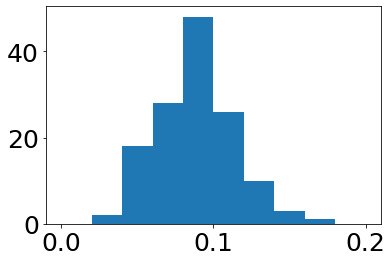

In [53]:
plt.hist(bf_ext[:,0],range=(0,0.2))
print(np.nanmedian(bf_ext[:,0]))
print(np.nanmedian(bf_ext[:,1]))

11.397379880165863
0.028828016101592063
11.36855186406427


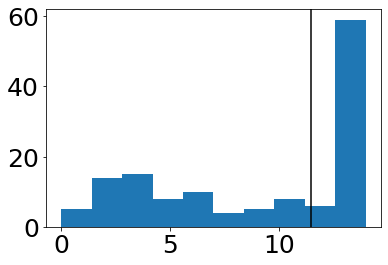

In [55]:
plt.hist(bf_age[:,0],range=(0,14))
plt.axvline(11.5,c='k')
print(np.nanmedian(bf_age[:,0]))
print(np.nanmedian(bf_age[:,1]))
print(np.nanmedian(bf_age[:,0])-np.nanmedian(bf_age[:,1]))

In [56]:
np.round(bf_age[:,0][np.where(bf_age[:,0]!=999999.0)],3)

array([ 6.498, 14.   ,  8.95 ,  3.965, 14.   ,  3.368,  9.091,  5.088,
       14.   , 14.   ,  5.861,  4.417,  2.531, 13.9  , 10.367,  6.85 ,
       11.175, 11.837,  1.657, 14.   ,  1.4  , 14.   , 14.   ,  7.675,
        2.13 , 12.075, 14.   ,  8.975,  6.333, 13.975,  8.387, 14.   ,
       14.   ,  3.103, 14.   , 14.   , 14.   ,  4.675, 14.   ,  4.3  ,
        2.025,  2.687,  1.704, 11.397, 14.   , 11.025,  6.575, 13.975,
       14.   ,  1.85 , 14.   ,  9.489,  2.85 , 13.9  , 14.   , 13.25 ,
        6.725, 13.75 ,  1.7  ,  2.994, 13.95 , 13.925,  1.4  , 14.   ,
       13.975, 13.575, 13.45 ,  2.092,  9.306, 14.   ,  6.485,  7.85 ,
        3.9  , 14.   ,  2.3  , 14.   ,  4.225, 11.084,  3.25 ,  4.362,
        4.369, 10.675,  6.6  ,  8.269,  2.725,  0.59 ,  1.852,  4.2  ,
        5.5  ,  3.7  , 13.25 , 13.925, 12.175, 12.6  , 13.975, 14.   ,
       12.725,  0.85 , 10.664, 14.   ,  3.325, 14.   , 13.6  ,  3.711,
       14.   , 14.   , 13.675, 14.   , 13.9  , 14.   , 12.725,  1.325,
      

<font size='15'>
    <b>
        Synthetic Data Offsets
    </b>
</font>

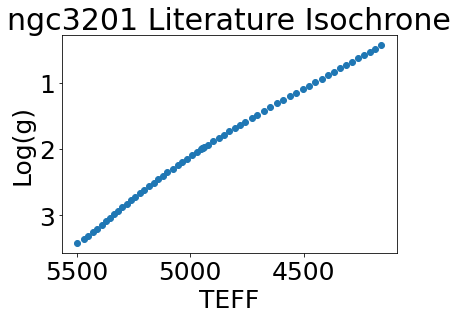

In [57]:
ngc3201_harfeh = harris_feh[np.where(gcs_clus=='NGC3201')]
ngc3201_vanfeh = vanden_feh[np.where(gcs_clus=='NGC3201')]
isochr = massive[np.where((massive['MH']==closest(massive['MH'],ngc3201_harfeh))&
                          (massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9))))]

plt.scatter(10**isochr['logTe'],isochr['logg'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('TEFF')
plt.ylabel('Log(g)')
plt.title('ngc3201 Literature Isochrone');

In [58]:
### Spectroscopic
synteff = np.random.normal(10**isochr['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isochr))
synfeh = np.random.normal(ngc3201_vanfeh,np.nanmedian(gcsdr17['FE_H_ERR']),len(isochr))

### With Extinction
synbpext = 999999.0*np.ones(len(isochr)) 
synrpext = 999999.0*np.ones(len(isochr)) 
synjext = 999999.0*np.ones(len(isochr)) 
synhext = 999999.0*np.ones(len(isochr)) 
synkext = 999999.0*np.ones(len(isochr))

# ## Random Distance Error 
# disterr = np.array([0.25,0.5,1.0,2.0,5.0])*1000

### Extinct Data
for i in range(len(isochr)):
    bpmag = (np.random.normal(isochr['G_BPmag'][i],np.nanmedian(bperr))+5*np.log10(3200)-5.0)
    rpmag = (np.random.normal(isochr['G_RPmag'][i],np.nanmedian(rperr))+5*np.log10(3200)-5.0)
    jmag = (np.random.normal(isochr['Jmag'][i],np.nanmedian(gcsdr17['J_ERR']))+5*np.log10(3200)-5.0)
    hmag = (np.random.normal(isochr['Hmag'][i],np.nanmedian(gcsdr17['H_ERR']))+5*np.log10(3200)-5.0)
    kmag = (np.random.normal(isochr['Ksmag'][i],np.nanmedian(gcsdr17['K_ERR']))+5*np.log10(3200)-5.0)
        
    # BP magnitudes
    if np.isfinite(bpmag)==True:
        synbpext[i] = bpmag+0.34*abp_ebv
    else:
        synbpext[i] = 999999.0

    # RP magnitudes
    if np.isfinite(rpmag)==True:
        synrpext[i] = rpmag+0.34*arp_ebv
    else:
        synrpext[i] = 999999.0

    # J magnitudes
    if np.isfinite(jmag)==True:
        synjext[i] = jmag+0.34*aj_ebv
    else:
        synjext[i] = 999999.0

    # H magnitudes
    if np.isfinite(hmag)==True:
        synhext[i] = hmag+0.34*ah_ebv
    else:
        synhext[i,j] = 999999.0

    # K magnitudes
    if np.isfinite(kmag)==True:
        synkext[i] = kmag+0.34*ak_ebv
    else:
        synkext[i] = 999999.0

# Synthetic Distance Modulus Offset

In [77]:
# dshift = np.random.uniform(0,2000,len(isochr))*(-1)**np.random.randint(2,size=len(isochr))
dmodshift = np.random.uniform(0,0.7)#*(-1)**np.random.randint(2,size=1)
print('Distance Mod Offset:',dmodshift)
    
### pick isochrone
isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9)))&
                           (massive['MH']==closest(massive['MH'],-1.51)))]
sorte = isopick[np.argsort(isopick['logTe'])]

### interpolate isochrones
bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])

### Calculate offsets    
bpngc3201dmod = bp_spl(synteff)-(synbpext-0.24*abp_ebv-5*np.log10(4900)+5.0-dmodshift)
rpngc3201dmod = rp_spl(synteff)-(synrpext-0.24*arp_ebv-5*np.log10(4900)+5.0-dmodshift)
jngc3201dmod = j_spl(synteff)-(synjext-0.24*aj_ebv-5*np.log10(4900)+5.0-dmodshift)
hngc3201dmod = h_spl(synteff)-(synhext-0.24*ah_ebv-5*np.log10(4900)+5.0-dmodshift)
kngc3201dmod = k_spl(synteff)-(synkext-0.24*ak_ebv-5*np.log10(4900)+5.0-dmodshift)

print('Median BP Shift:',np.median(bpngc3201dmod))
print('Median RP Shift:',np.median(rpngc3201dmod))
print('Median J Shift:',np.median(jngc3201dmod))
print('Median H Shift:',np.median(hngc3201dmod))
print('Median K Shift:',np.median(kngc3201dmod))

Distance Mod Offset: 0.281723089268533
Median BP Shift: 0.8798092448211143
Median RP Shift: 1.0001456053460218
Median J Shift: 1.1166502187337901
Median H Shift: 1.1552840068421444
Median K Shift: 1.1816155998234472


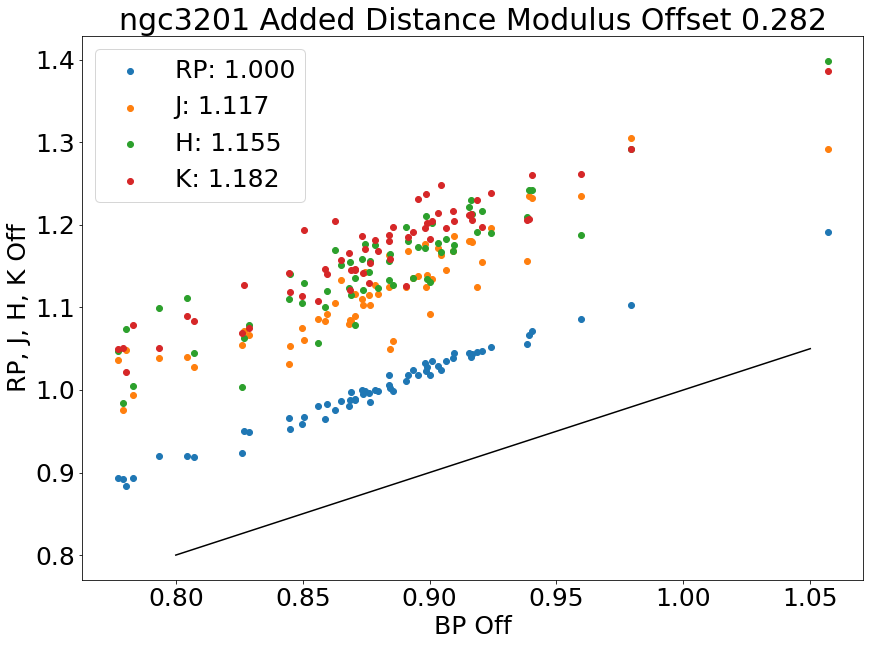

In [80]:
plt.figure(figsize=[14,10])
plt.scatter(bpngc3201dmod,rpngc3201dmod,label='RP: {:.3f}'.format(np.median(rpngc3201dmod)))
plt.scatter(bpngc3201dmod,jngc3201dmod,label='J: {:.3f}'.format(np.median(jngc3201dmod)))
plt.scatter(bpngc3201dmod,hngc3201dmod,label='H: {:.3f}'.format(np.median(hngc3201dmod)))
plt.scatter(bpngc3201dmod,kngc3201dmod,label='K: {:.3f}'.format(np.median(kngc3201dmod)))
plt.legend()
plt.plot([0.8,1.05],[0.8,1.05],c='k')
plt.title('ngc3201 Added Distance Modulus Offset {:.3f}'.format(dmodshift))
plt.xlabel('BP Off')
plt.ylabel('RP, J, H, K Off')
plt.savefig('../plots/NGC3201DistModOff.pdf')

In [27]:
print('Distance for +/- 0.5:',10**((0.5+5.)/5.))

Distance for +/- 0.5: 12.589254117941675


In [28]:
# allclusbp = 999999.0*np.ones((len(gcs_clus),100,62))
# allclusrp = 999999.0*np.ones((len(gcs_clus),100))
# allclusj = 999999.0*np.ones((len(gcs_clus),100))
# allclush = 999999.0*np.ones((len(gcs_clus),100))
# allclusk = 999999.0*np.ones((len(gcs_clus),100))

# alldmodshift = np.random.uniform(0,0.7,100)*(-1)**np.random.randint(2,size=100)
# for i in tqdm_notebook(range(len(gcs_clus))):

#     ### pick isochrone
#     isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i])))&
#                                (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#     sorte = isopick[np.argsort(isopick['logTe'])]

#     ### interpolate isochrones
#     bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
#     rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
#     j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
#     h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
#     k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])
    
#     ### Calculate offsets    
#     for j in range(100):
#         allclusbp[i,j] = bp_spl(synteff)-(synbpext-0.34*abp_ebv-5*np.log10(3200)+5.0-alldmodshift[j])
#         allclusrp[i,j] = rp_spl(synteff)-(synrpext-0.34*arp_ebv-5*np.log10(3200)+5.0-alldmodshift[j])
#         allclusj[i,j] = j_spl(synteff)-(synjext-0.34*aj_ebv-5*np.log10(3200)+5.0-alldmodshift[j])
#         allclush[i,j] = h_spl(synteff)-(synhext-0.34*ah_ebv-5*np.log10(3200)+5.0-alldmodshift[j])
#         allclusk[i,j] = k_spl(synteff)-(synkext-0.34*ak_ebv-5*np.log10(3200)+5.0-alldmodshift[j])

# Synthetic [Fe/H] Offset

In [81]:
fehshift = np.random.uniform(0,-1.1)#*(-1)**np.random.randint(2,size=1)
print('[Fe/H] Offset:',fehshift)
    
### pick isochrone
isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9)))&
                           (massive['MH']==closest(massive['MH'],-1.51+fehshift)))]
sorte = isopick[np.argsort(isopick['logTe'])]

### interpolate isochrones
bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])

### Calculate offsets    
bpngc3201feh = bp_spl(synteff)-(synbpext-0.34*abp_ebv-5*np.log10(4900)+5.0)
rpngc3201feh = rp_spl(synteff)-(synrpext-0.34*arp_ebv-5*np.log10(4900)+5.0)
jngc3201feh = j_spl(synteff)-(synjext-0.34*aj_ebv-5*np.log10(4900)+5.0)
hngc3201feh = h_spl(synteff)-(synhext-0.34*ah_ebv-5*np.log10(4900)+5.0)
kngc3201feh = k_spl(synteff)-(synkext-0.34*ak_ebv-5*np.log10(4900)+5.0)

print('Median BP Shift:',np.median(bpngc3201feh))
print('Median RP Shift:',np.median(rpngc3201feh))
print('Median J Shift:',np.median(jngc3201feh))
print('Median H Shift:',np.median(hngc3201feh))
print('Median K Shift:',np.median(kngc3201feh))

[Fe/H] Offset: -0.7845036770776854
Median BP Shift: 0.24044807252409323
Median RP Shift: 0.23216456390426576
Median J Shift: 0.22467356228448043
Median H Shift: 0.22707430166254117
Median K Shift: 0.22398854464413454


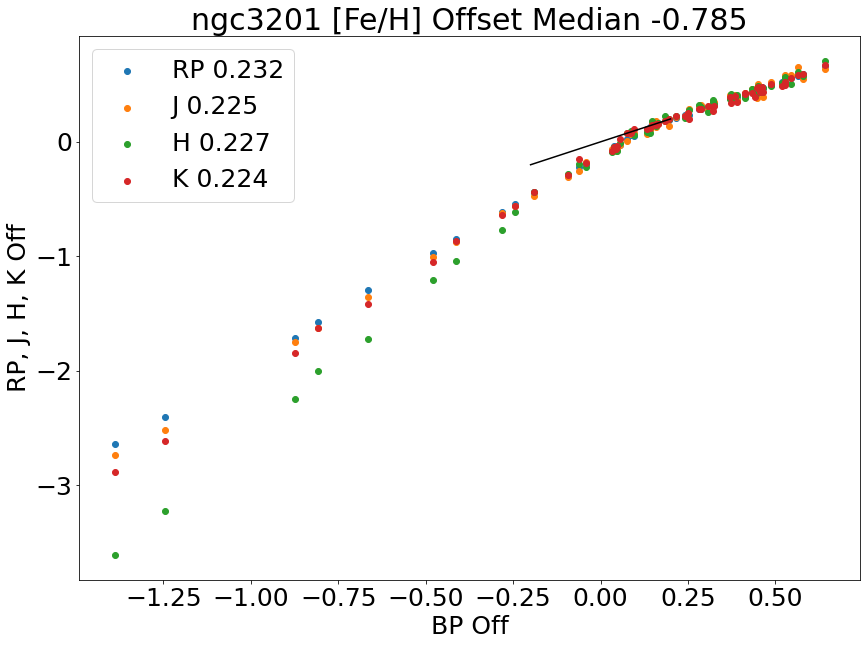

In [82]:
plt.figure(figsize=[14,10])
plt.scatter(bpngc3201feh,rpngc3201feh,label='RP {:.3f}'.format(np.median(rpngc3201feh)))
plt.scatter(bpngc3201feh,jngc3201feh,label='J {:.3f}'.format(np.median(jngc3201feh)))
plt.scatter(bpngc3201feh,hngc3201feh,label='H {:.3f}'.format(np.median(hngc3201feh)))
plt.scatter(bpngc3201feh,kngc3201feh,label='K {:.3f}'.format(np.median(kngc3201feh)))
plt.legend()
plt.plot([-0.2,0.2],[-0.2,0.2],c='k')
plt.title(r'ngc3201 [Fe/H] Offset Median {:.3f}'.format(fehshift))
plt.xlabel('BP Off')
plt.ylabel('RP, J, H, K Off')
plt.savefig('../plots/NGC3201FeHModOff.pdf')
plt.show()

In [31]:
# same four plots for another cluster

In [84]:
n = 100
bpngc3201fehall = 999999.0*np.ones((len(isochr),n))
rpngc3201fehall = 999999.0*np.ones((len(isochr),n))
jngc3201fehall = 999999.0*np.ones((len(isochr),n))
hngc3201fehall = 999999.0*np.ones((len(isochr),n))
kngc3201fehall = 999999.0*np.ones((len(isochr),n))

fehshiftall = np.random.uniform(0,0.7,n)*(-1)**np.random.randint(2,size=n)

for j in tqdm_notebook(range(n)):
    ### pick isochrone
    isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9)))&
                               (massive['MH']==closest(massive['MH'],-1.7+fehshiftall[j])))]
    sorte = isopick[np.argsort(isopick['logTe'])]

    ### interpolate isochrones
    bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
    rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
    j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
    h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
    k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])

    ### Calculate offsets    
    bpngc3201fehall[:,j] = bp_spl(synteff)-(synbpext-0.24*abp_ebv-5*np.log10(4900)+5.0)
    rpngc3201fehall[:,j] = rp_spl(synteff)-(synrpext-0.24*arp_ebv-5*np.log10(4900)+5.0)
    jngc3201fehall[:,j] = j_spl(synteff)-(synjext-0.24*aj_ebv-5*np.log10(4900)+5.0)
    hngc3201fehall[:,j] = h_spl(synteff)-(synhext-0.24*ah_ebv-5*np.log10(4900)+5.0)
    kngc3201fehall[:,j] = k_spl(synteff)-(synkext-0.24*ak_ebv-5*np.log10(4900)+5.0)

#     print('Median BP Shift:',np.median(bpngc3201feh))
#     print('Median RP Shift:',np.median(rpngc3201feh))
#     print('Median J Shift:',np.median(jngc3201feh))
#     print('Median H Shift:',np.median(hngc3201feh))
#     print('Median K Shift:',np.median(kngc3201feh))

In [85]:
bpngc3201fehshifts = np.array([])
rpngc3201fehshifts = np.array([])
jngc3201fehshifts = np.array([])
hngc3201fehshifts = np.array([])
kngc3201fehshifts = np.array([])

for i in tqdm_notebook(range(n)):
    bpngc3201fehshifts = np.append(bpngc3201fehshifts,np.nanmedian(bpngc3201fehall[:,i]))
    rpngc3201fehshifts = np.append(rpngc3201fehshifts,np.nanmedian(rpngc3201fehall[:,i]))
    jngc3201fehshifts = np.append(jngc3201fehshifts,np.nanmedian(jngc3201fehall[:,i]))
    hngc3201fehshifts = np.append(hngc3201fehshifts,np.nanmedian(hngc3201fehall[:,i]))
    kngc3201fehshifts = np.append(kngc3201fehshifts,np.nanmedian(kngc3201fehall[:,i]))

In [86]:
bpngc3201fehshifts

array([ 1.30087898,  0.38842684,  0.06379851,  0.55195791, -0.09034894,
        0.11974226,  0.30532305, -0.09034894,  1.17797252, -0.01632316,
        0.36383951,  0.89916716, -0.09034894,  0.07595925, -0.09034894,
       -0.09034894,  0.06379851,  1.0018483 ,  0.84688237, -0.06040981,
       -0.09034894,  0.62383495,  0.44714765,  0.53900737,  1.07032342,
        0.08205455,  0.00174089,  0.01931443,  0.76410924,  0.43260564,
        0.51527729,  0.02311588,  0.3723624 ,  0.65875921,  1.05300621,
       -0.09034894, -0.09034894,  0.05858051,  1.03516638,  0.53900737,
        0.15865718, -0.09034894, -0.09034894,  1.27932871,  0.55195791,
        1.40052493,  0.72925499,  0.00174089, -0.09034894, -0.09034894,
        0.02908342,  0.14251948,  1.12164412,  0.00174089, -0.067085  ,
        1.32001409,  0.17499444, -0.05437691,  0.27539864,  0.53900737,
        0.21872198,  0.04735385,  1.27932871,  0.48802841,  0.3723624 ,
       -0.07198466, -0.09034894,  0.0699414 ,  0.3723624 ,  1.40

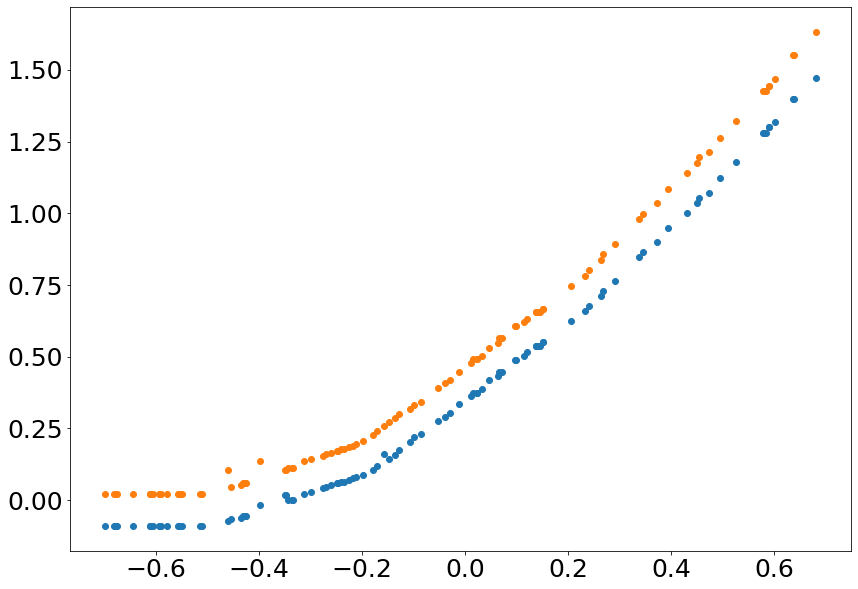

In [87]:
plt.figure(figsize=[14,10])
plt.scatter(fehshiftall,bpngc3201fehshifts)
plt.scatter(fehshiftall,rpngc3201fehshifts)

In [36]:
np.size(np.array([-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0]))

11

In [37]:
# clusfehshift = np.array([-1.0,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])

# allbpfeh = 999999.0*np.ones((len(gcs_clus),len(clusfehshift)))
# allrpfeh = 999999.0*np.ones((len(gcs_clus),len(clusfehshift)))
# alljfeh = 999999.0*np.ones((len(gcs_clus),len(clusfehshift)))
# allhfeh = 999999.0*np.ones((len(gcs_clus),len(clusfehshift)))
# allkfeh = 999999.0*np.ones((len(gcs_clus),len(clusfehshift)))

# for i in tqdm_notebook(range(len(gcs_clus))):
#     # Pick Cluster
#     clus = np.where(gcs['CLUSTER'] == gcs_clus[i])
    
#     for j in range(len(clusfehshift)):
#         # Select Isochrone To Create Synthetic Data
#         isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9)))&
#                                    (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#         isopick = isopick[np.argsort(isopick['logTe'])]
        
#         # Create Synthetic Spectroscopy
#         synclusteff = np.random.normal(10**isopick['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isopick))
#         synclusfeh = (np.random.normal(vanden_feh[i],np.nanmedian(gcsdr17['FE_H_ERR']),len(isopick)))
        
#         # Create Synthetic Photometry
#         synbpclus = 999999.0*np.ones(len(isopick))
#         synrpclus = 999999.0*np.ones(len(isopick))
#         synjclus = 999999.0*np.ones(len(isopick))
#         synhclus = 999999.0*np.ones(len(isopick))
#         synkclus = 999999.0*np.ones(len(isopick))
        
#         for k in range(len(isopick)):
#             bpmag = (np.random.normal(isopick['G_BPmag'][j],np.nanmedian(bperr))+5*np.log10(harris_dist[i])-5.0)
#             rpmag = (np.random.normal(isopick['G_RPmag'][j],np.nanmedian(rperr))+5*np.log10(harris_dist[i])-5.0)
#             jmag = (np.random.normal(isopick['Jmag'][j],np.nanmedian(gcsdr17['J_ERR']))+5*np.log10(harris_dist[i])-5.0)
#             hmag = (np.random.normal(isopick['Hmag'][j],np.nanmedian(gcsdr17['H_ERR']))+5*np.log10(harris_dist[i])-5.0)
#             kmag = (np.random.normal(isopick['Ksmag'][j],np.nanmedian(gcsdr17['K_ERR']))+5*np.log10(harris_dist[i])-5.0)

#             # BP magnitudes
#             if np.isfinite(bpmag)==True:
#                 synbpext[j] = bpmag+0.34*abp_ebv
#             else:
#                 synbpext[j] = 999999.0

#             # RP magnitudes
#             if np.isfinite(rpmag)==True:
#                 synrpext[j] = rpmag+0.34*arp_ebv
#             else:
#                 synrpext[j] = 999999.0

#             # J magnitudes
#             if np.isfinite(jmag)==True:
#                 synjext[j] = jmag+0.34*aj_ebv
#             else:
#                 synjext[j] = 999999.0

#             # H magnitudes
#             if np.isfinite(hmag)==True:
#                 synhext[j] = hmag+0.34*ah_ebv
#             else:
#                 synhext[j] = 999999.0

#             # K magnitudes
#             if np.isfinite(kmag)==True:
#                 synkext[j] = kmag+0.34*ak_ebv
#             else:
#                 synkext[j] = 999999.0
                
#         ### Get Individual Shifts
#         # Select isochrone to spline
#         isopick2 = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9)))&
#                                    (massive['MH']==closest(massive['MH'],vanden_feh[i]+clusfehshift[j])))]
#         isopick2 = isopick2[np.argsort(isopick2['logTe'])]
        
#         # Splines For Interpolation
#         bp_spl = IUS(10**isopick2['logTe'][::2],isopick2['G_BPmag'][::2])
#         rp_spl = IUS(10**isopick2['logTe'][::2],isopick2['G_RPmag'][::2])
#         j_spl = IUS(10**isopick2['logTe'][::2],isopick2['Jmag'][::2])
#         h_spl = IUS(10**isopick2['logTe'][::2],isopick2['Hmag'][::2])
#         k_spl = IUS(10**isopick2['logTe'][::2],isopick2['Ksmag'][::2])
        
        
#         bpclusshift = bp_spl(synteff)-(synbpext-0.34*abp_ebv-5*np.log10(harris_dist[i])+5.0)
#         rpclusshift = rp_spl(synteff)-(synrpext-0.34*arp_ebv-5*np.log10(harris_dist[i])+5.0)
#         jclusshift = j_spl(synteff)-(synjext-0.34*aj_ebv-5*np.log10(harris_dist[i])+5.0)
#         hclusshift = h_spl(synteff)-(synhext-0.34*ah_ebv-5*np.log10(harris_dist[i])+5.0)
#         kclusshift = k_spl(synteff)-(synkext-0.34*ak_ebv-5*np.log10(harris_dist[i])+5.0)
        
#         allbpfeh[i,j] = np.nanmedian(bpclusshift)
#         allrpfeh[i,j] = np.nanmedian(rpclusshift)
#         alljfeh[i,j] = np.nanmedian(jclusshift)
#         allhfeh[i,j] = np.nanmedian(hclusshift)
#         allkfeh[i,j] = np.nanmedian(kclusshift)

In [38]:
# fehlabels = clusfehshift.astype(str)
# plt.figure(figsize=[30,55])
# plt.suptitle(r'[Fe/H] Magnitude Offset With Synthetic Data',y=0.9)
# ###
# plt.subplot(511)
# for i in range(11):
#     plt.scatter(range(30),allbpfeh[:,i],label='{} dex'.format(fehlabels[i]))
#     plt.plot(range(30),allbpfeh[:,i])
# plt.ylim(top=6)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('BP Offset')
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(512)
# for i in range(11):
#     plt.scatter(range(30),allrpfeh[:,i],label='{} dex'.format(fehlabels[i]))
#     plt.plot(range(30),allrpfeh[:,i])
# plt.ylim(top=6)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('RP Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(513)
# for i in range(11):
#     plt.scatter(range(30),alljfeh[:,i],label='{} dex'.format(fehlabels[i]))
#     plt.plot(range(30),alljfeh[:,i])
# plt.ylim(top=6)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('J Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(514)
# for i in range(11):
#     plt.scatter(range(30),allhfeh[:,i],label='{} dex'.format(fehlabels[i]))
#     plt.plot(range(30),allhfeh[:,i])
# plt.ylim(top=6)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('H Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(515)
# for i in range(11):
#     plt.scatter(range(30),allkfeh[:,i],label='{} dex'.format(fehlabels[i]))
#     plt.plot(range(30),allkfeh[:,i])
# plt.ylim(top=6)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('K Offset')
# plt.xticks(range(30),labels=list(gcs_clus),rotation='vertical')
# plt.grid(True)
# plt.savefig('synclusfehoff.pdf',bbox_iches='tight')
# plt.show()

In [39]:
# for i in tqdm_notebook(range(len(gcs_clus))):
#     clus = np.where(gcs['CLUSTER']==gcs_clus[i])
    
#     isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9)))&
#                                (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#     isopick = isopick[np.argsort(isopick['logTe'])]
    
#     ### interpolate isochrones
#     bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
#     rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
#     j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
#     h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
#     k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])
    
#     ### distance modulus error
#     dclusshift = np.random.uniform(0,0.07,len(isopick))*(-1)**np.random.randint(2,size=len(isopick))
    
#     ### Spectroscopic
#     synteff = np.random.normal(10**isopick['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isopick))
#     synfeh = np.random.normal(m22_vanfeh,np.nanmedian(gcsdr17['FE_H_ERR']),len(isopick))

#     ### With Extinction
#     synbpext = 999999.0*np.ones(len(isopick)) 
#     synrpext = 999999.0*np.ones(len(isopick)) 
#     synjext = 999999.0*np.ones(len(isopick)) 
#     synhext = 999999.0*np.ones(len(isopick)) 
#     synkext = 999999.0*np.ones(len(isopick))
    
#     ### Extinct Data
#     for j in range(len(isopick)):
#         bpmag = (np.random.normal(isopick['G_BPmag'][j],np.nanmedian(bperr))+5*np.log10(harris_dist[i])-5.0)
#         rpmag = (np.random.normal(isopick['G_RPmag'][j],np.nanmedian(rperr))+5*np.log10(harris_dist[i])-5.0)
#         jmag = (np.random.normal(isopick['Jmag'][j],np.nanmedian(gcsdr17['J_ERR']))+5*np.log10(harris_dist[i])-5.0)
#         hmag = (np.random.normal(isopick['Hmag'][j],np.nanmedian(gcsdr17['H_ERR']))+5*np.log10(harris_dist[i])-5.0)
#         kmag = (np.random.normal(isopick['Ksmag'][j],np.nanmedian(gcsdr17['K_ERR']))+5*np.log10(harris_dist[i])-5.0)

#         # BP magnitudes
#         if np.isfinite(bpmag)==True:
#             synbpext[j] = bpmag+0.34*abp_ebv
#         else:
#             synbpext[j] = 999999.0

#         # RP magnitudes
#         if np.isfinite(rpmag)==True:
#             synrpext[j] = rpmag+0.34*arp_ebv
#         else:
#             synrpext[j] = 999999.0

#         # J magnitudes
#         if np.isfinite(jmag)==True:
#             synjext[j] = jmag+0.34*aj_ebv
#         else:
#             synjext[j] = 999999.0

#         # H magnitudes
#         if np.isfinite(hmag)==True:
#             synhext[j] = hmag+0.34*ah_ebv
#         else:
#             synhext[j] = 999999.0

#         # K magnitudes
#         if np.isfinite(kmag)==True:
#             synkext[j] = kmag+0.34*ak_ebv
#         else:
#             synkext[j] = 999999.0
    
#     ### Calculate Shifts
#     bpshifts = []
#     rpshifts = []
#     jshifts = []
#     hshifts = []
#     kshifts = []
    
#     distance = harris_dist[i] 
#     for k in range(len(isopick)):

#         ### Calculate offsets    
#         bpshifts.append(bp_spl(synteff)-(synbpext-0.34*abp_ebv-5*np.log10(distance)+5.0+dclusshift[k]))
#         rpshifts.append(rp_spl(synteff)-(synrpext-0.34*arp_ebv-5*np.log10(distance)+5.0+dclusshift[k]))
#         jshifts.append(j_spl(synteff)-(synjext-0.34*aj_ebv-5*np.log10(distance)+5.0+dclusshift[k]))
#         hshifts.append(h_spl(synteff)-(synhext-0.34*ah_ebv-5*np.log10(distance)+5.0+dclusshift[k]))
#         kshifts.append(k_spl(synteff)-(synkext-0.34*ak_ebv-5*np.log10(distance)+5.0+dclusshift[k]))
        
        
#     offsbp = 999999.0*np.ones(len(isopick))
#     offsrp = 999999.0*np.ones(len(isopick))
#     offsj = 999999.0*np.ones(len(isopick))
#     offsh = 999999.0*np.ones(len(isopick))
#     offsk = 999999.0*np.ones(len(isopick))

#     for l in range(len(isopick)):
#         offsbp[l] = np.nanmedian(bpshifts[l])
#         offsrp[l] = np.nanmedian(rpshifts[l])
#         offsj[l] = np.nanmedian(jshifts[l])
#         offsh[l] = np.nanmedian(hshifts[l])
#         offsk[l] = np.nanmedian(kshifts[l])

#     plt.figure(figsize=[14,10])
#     plt.scatter(dclusshift,offsbp,marker='D',c='purple',label='BP')
#     plt.scatter(dclusshift,offsrp,marker='D',c='blue',label='RP')
#     plt.scatter(dclusshift,offsj,marker='D',c='green',label='J')
#     plt.scatter(dclusshift,offsh,marker='D',c='orange',label='H')
#     plt.scatter(dclusshift,offsk,marker='D',c='red',label='K')

# #     plt.axhline(-0.5,c='k')
# #     plt.axhline(0.5,c='k')

# #     plt.axvline(700)

#     plt.legend()
#     plt.title(r'{} Lit Distance {}'.format(gcs_clus[i],harris_dist[i]))
#     plt.xlabel(r'Added Distance Modulus Error (kpc)')
#     plt.ylabel(r'Offset')
#     plt.show()
    
#     plt.figure(figsize=[14,10])
#     plt.scatter(offsbp,offsrp,marker='D',c='b',label='RP')
#     plt.scatter(offsbp,offsj,marker='D',c='g',label='J')
#     plt.scatter(offsbp,offsh,marker='D',c='orange',label='H')
#     plt.scatter(offsbp,offsk,marker='D',c='r',label='K')
#     plt.legend(frameon=False)
#     plt.title(r'{} Lit Distance {}'.format(gcs_clus[i],harris_dist[i]))
#     plt.xlabel('BPOFF')
#     plt.ylabel('RP, J, H, KOFF')
#     plt.show()

# Synthetic Age Offset 

In [88]:
ageshift = np.random.uniform(0,5*10**9)#*(-1)**np.random.randint(2,size=1)
print('Age Offset:',ageshift/10**9)
    
### pick isochrone
isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9+ageshift)))&
                           (massive['MH']==closest(massive['MH'],-1.7)))]
sorte = isopick[np.argsort(isopick['logTe'])]

### interpolate isochrones
bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])

### Calculate offsets    
bpngc3201age = bp_spl(synteff)-(synbpext-0.24*abp_ebv-5*np.log10(4900)+5.0)
rpngc3201age = rp_spl(synteff)-(synrpext-0.24*arp_ebv-5*np.log10(4900)+5.0)
jngc3201age = j_spl(synteff)-(synjext-0.24*aj_ebv-5*np.log10(4900)+5.0)
hngc3201age = h_spl(synteff)-(synhext-0.24*ah_ebv-5*np.log10(4900)+5.0)
kngc3201age = k_spl(synteff)-(synkext-0.24*ak_ebv-5*np.log10(4900)+5.0)

print('Median BP Shift:',np.median(bpngc3201age))
print('Median RP Shift:',np.median(rpngc3201age))
print('Median J Shift:',np.median(jngc3201age))
print('Median H Shift:',np.median(hngc3201age))
print('Median K Shift:',np.median(kngc3201age))

Age Offset: 3.116680563088155
Median BP Shift: 0.3968151051283959
Median RP Shift: 0.5115199818192742
Median J Shift: 0.6486682202522056
Median H Shift: 0.668597129789827
Median K Shift: 0.6961227483821038


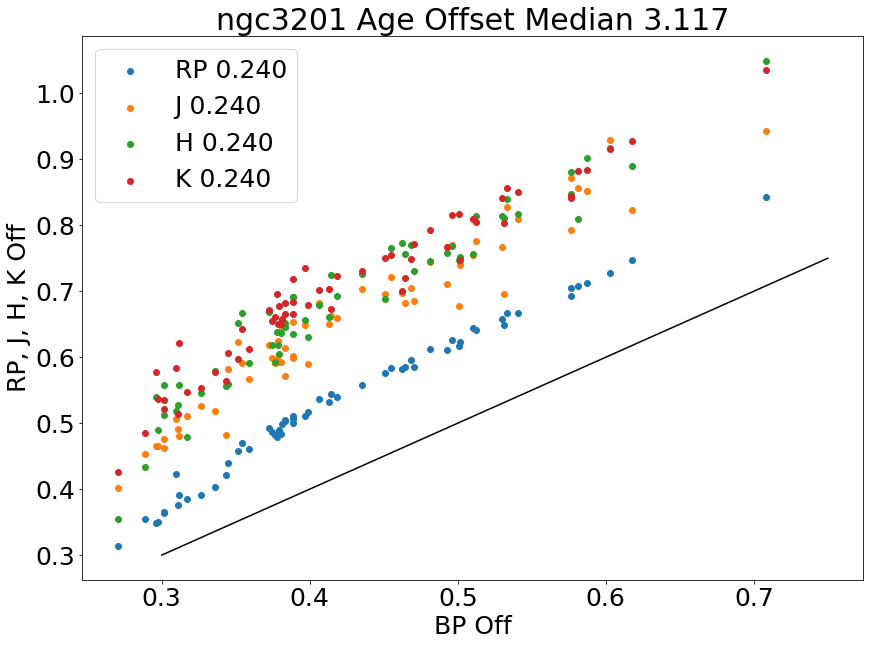

In [92]:
plt.figure(figsize=[14,10])
plt.scatter(bpngc3201age,rpngc3201age,label='RP {:.3f}'.format(np.median(bpngc3201feh)))
plt.scatter(bpngc3201age,jngc3201age,label='J {:.3f}'.format(np.median(bpngc3201feh)))
plt.scatter(bpngc3201age,hngc3201age,label='H {:.3f}'.format(np.median(bpngc3201feh)))
plt.scatter(bpngc3201age,kngc3201age,label='K {:.3f}'.format(np.median(bpngc3201feh)))
plt.legend()
plt.plot([0.3,0.75],[0.3,0.75],c='k')
plt.title(r'ngc3201 Age Offset Median {:.3f}'.format(ageshift/10**9))
plt.xlabel('BP Off')
plt.ylabel('RP, J, H, K Off')
plt.savefig('../plots/NGC3201AgeModOff.pdf')
plt.show()

In [42]:
# clusageshift = np.array([-5.0,-2.0,-1.0,-0.5,-0.25,0.0,0.25,0.5,1.0,2.0,5.0])

# allbpage = 999999.0*np.ones((len(gcs_clus),len(clusageshift)))
# allrpage = 999999.0*np.ones((len(gcs_clus),len(clusageshift)))
# alljage = 999999.0*np.ones((len(gcs_clus),len(clusageshift)))
# allhage = 999999.0*np.ones((len(gcs_clus),len(clusageshift)))
# allkage = 999999.0*np.ones((len(gcs_clus),len(clusageshift)))

# for i in tqdm_notebook(range(len(gcs_clus))):
#     # Pick Cluster
#     clus = np.where(gcs['CLUSTER'] == gcs_clus[i])
    
#     for j in range(len(clusageshift)):
#         # Select Isochrone To Create Synthetic Data
#         isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9)))&
#                                    (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#         isopick = isopick[np.argsort(isopick['logTe'])]
        
#         # Create Synthetic Spectroscopy
#         synclusteff = np.random.normal(10**isopick['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isopick))
#         synclusfeh = (np.random.normal(vanden_feh[i],np.nanmedian(gcsdr17['FE_H_ERR']),len(isopick)))
        
#         # Create Synthetic Photometry
#         synbpclus = 999999.0*np.ones(len(isopick))
#         synrpclus = 999999.0*np.ones(len(isopick))
#         synjclus = 999999.0*np.ones(len(isopick))
#         synhclus = 999999.0*np.ones(len(isopick))
#         synkclus = 999999.0*np.ones(len(isopick))
        
#         for k in range(len(isopick)):
#             bpmag = (np.random.normal(isopick['G_BPmag'][j],np.nanmedian(bperr))+5*np.log10(harris_dist[i])-5.0)
#             rpmag = (np.random.normal(isopick['G_RPmag'][j],np.nanmedian(rperr))+5*np.log10(harris_dist[i])-5.0)
#             jmag = (np.random.normal(isopick['Jmag'][j],np.nanmedian(gcsdr17['J_ERR']))+5*np.log10(harris_dist[i])-5.0)
#             hmag = (np.random.normal(isopick['Hmag'][j],np.nanmedian(gcsdr17['H_ERR']))+5*np.log10(harris_dist[i])-5.0)
#             kmag = (np.random.normal(isopick['Ksmag'][j],np.nanmedian(gcsdr17['K_ERR']))+5*np.log10(harris_dist[i])-5.0)

#             # BP magnitudes
#             if np.isfinite(bpmag)==True:
#                 synbpext[j] = bpmag+0.34*abp_ebv
#             else:
#                 synbpext[j] = 999999.0

#             # RP magnitudes
#             if np.isfinite(rpmag)==True:
#                 synrpext[j] = rpmag+0.34*arp_ebv
#             else:
#                 synrpext[j] = 999999.0

#             # J magnitudes
#             if np.isfinite(jmag)==True:
#                 synjext[j] = jmag+0.34*aj_ebv
#             else:
#                 synjext[j] = 999999.0

#             # H magnitudes
#             if np.isfinite(hmag)==True:
#                 synhext[j] = hmag+0.34*ah_ebv
#             else:
#                 synhext[j] = 999999.0

#             # K magnitudes
#             if np.isfinite(kmag)==True:
#                 synkext[j] = kmag+0.34*ak_ebv
#             else:
#                 synkext[j] = 999999.0
                
#         ### Get Individual Shifts
#         # Select isochrone to spline
#         isopick2 = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10((vanden_age[i]+clusageshift[j])*10**9)))&
#                                     (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#         isopick2 = isopick2[np.argsort(isopick2['logTe'])]
        
#         # Splines For Interpolation
#         bp_spl = IUS(10**isopick2['logTe'][::2],isopick2['G_BPmag'][::2])
#         rp_spl = IUS(10**isopick2['logTe'][::2],isopick2['G_RPmag'][::2])
#         j_spl = IUS(10**isopick2['logTe'][::2],isopick2['Jmag'][::2])
#         h_spl = IUS(10**isopick2['logTe'][::2],isopick2['Hmag'][::2])
#         k_spl = IUS(10**isopick2['logTe'][::2],isopick2['Ksmag'][::2])
        
        
#         bpclusshift = bp_spl(synteff)-(synbpext-0.34*abp_ebv-5*np.log10(harris_dist[i])+5.0)
#         rpclusshift = rp_spl(synteff)-(synrpext-0.34*arp_ebv-5*np.log10(harris_dist[i])+5.0)
#         jclusshift = j_spl(synteff)-(synjext-0.34*aj_ebv-5*np.log10(harris_dist[i])+5.0)
#         hclusshift = h_spl(synteff)-(synhext-0.34*ah_ebv-5*np.log10(harris_dist[i])+5.0)
#         kclusshift = k_spl(synteff)-(synkext-0.34*ak_ebv-5*np.log10(harris_dist[i])+5.0)
        
#         allbpage[i,j] = np.nanmedian(bpclusshift)
#         allrpage[i,j] = np.nanmedian(rpclusshift)
#         alljage[i,j] = np.nanmedian(jclusshift)
#         allhage[i,j] = np.nanmedian(hclusshift)
#         allkage[i,j] = np.nanmedian(kclusshift)

In [43]:
# agelabels = clusageshift.astype(str)
# plt.figure(figsize=[30,55])
# plt.suptitle(r'Age Magnitude Offset With Synthetic Data',y=0.9)
# ###
# plt.subplot(511)
# for i in range(11):
#     plt.scatter(range(30),allbpage[:,i],label='{} Gyr'.format(agelabels[i]))
#     plt.plot(range(30),allbpage[:,i])
# plt.ylim(top=4)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('BP Offset')
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(512)
# for i in range(11):
#     plt.scatter(range(30),allrpage[:,i],label='{} Gyr'.format(agelabels[i]))
#     plt.plot(range(30),allrpage[:,i])
# plt.ylim(top=4)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('RP Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(513)
# for i in range(11):
#     plt.scatter(range(30),alljage[:,i],label='{} Gyr'.format(agelabels[i]))
#     plt.plot(range(30),alljage[:,i])
# plt.ylim(top=4)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('J Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(514)
# for i in range(11):
#     plt.scatter(range(30),allhage[:,i],label='{} Gyr'.format(agelabels[i]))
#     plt.plot(range(30),allhage[:,i])
# plt.ylim(top=4)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('H Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(515)
# for i in range(11):
#     plt.scatter(range(30),allkage[:,i],label='{} Gyr'.format(agelabels[i]))
#     plt.plot(range(30),allkage[:,i])
# plt.ylim(top=4)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('K Offset')
# plt.xticks(range(30),labels=list(gcs_clus),rotation='vertical')
# plt.grid(True)
# plt.savefig('synclusageoff.pdf',bbox_iches='tight')
# plt.show()

# Synthetic AK Offset

In [44]:
akshift = np.random.uniform(0,2.0)*(-1)**np.random.randint(2,size=1)
akshift

array([1.00948433])

In [93]:
ngc3201_harfeh = harris_feh[np.where(gcs_clus=='ngc3201')]
ngc3201_vanfeh = vanden_feh[np.where(gcs_clus=='ngc3201')]
isochr = massive[np.where((massive['MH']==closest(massive['MH'],-1.51))&
                          (massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9))))]

### Spectroscopic
synteff = np.random.normal(10**isochr['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isochr))
synfeh = np.random.normal(-1.51,np.nanmedian(gcsdr17['FE_H_ERR']),len(isochr))

### With Extinction
synbpext = 999999.0*np.ones(len(isochr)) 
synrpext = 999999.0*np.ones(len(isochr)) 
synjext = 999999.0*np.ones(len(isochr))
synhext = 999999.0*np.ones(len(isochr)) 
synkext = 999999.0*np.ones(len(isochr))

# ## Random Distance Error 
# disterr = np.array([0.25,0.5,1.0,2.0,5.0])*1000

### Extinct Data
for i in range(len(isochr)):
    bpmag = (np.random.normal(isochr['G_BPmag'][i],np.nanmedian(bperr))+5*np.log10(4900)-5.0)
    rpmag = (np.random.normal(isochr['G_RPmag'][i],np.nanmedian(rperr))+5*np.log10(4900)-5.0)
    jmag = (np.random.normal(isochr['Jmag'][i],np.nanmedian(gcsdr17['J_ERR']))+5*np.log10(4900)-5.0)
    hmag = (np.random.normal(isochr['Hmag'][i],np.nanmedian(gcsdr17['H_ERR']))+5*np.log10(4900)-5.0)
    kmag = (np.random.normal(isochr['Ksmag'][i],np.nanmedian(gcsdr17['K_ERR']))+5*np.log10(4900)-5.0)
        
    # BP magnitudes
    if np.isfinite(bpmag)==True:
        synbpext[i] = bpmag+0.34*abp_ebv
    else:
        synbpext[i] = 999999.0

    # RP magnitudes
    if np.isfinite(rpmag)==True:
        synrpext[i] = rpmag+0.34*arp_ebv
    else:
        synrpext[i] = 999999.0

    # J magnitudes
    if np.isfinite(jmag)==True:
        synjext[i] = jmag+0.34*aj_ebv
    else:
        synjext[i] = 999999.0

    # H magnitudes
    if np.isfinite(hmag)==True:
        synhext[i] = hmag+0.34*ah_ebv
    else:
        synhext[i,j] = 999999.0

    # K magnitudes
    if np.isfinite(kmag)==True:
        synkext[i] = kmag+0.34*ak_ebv
    else:
        synkext[i] = 999999.0

akshift = np.random.uniform(0,2.0)#*(-1)**np.random.randint(2,size=1)
abp_ak = ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1)
arp_ak = ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1)
aj_ak = ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)
ah_ak = ccm_alav(leff['K'],3.1)/ccm_alav(leff['K'],3.1)
print('Ak Offset:',akshift)
    
### pick isochrone
isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(12.5*10**9)))&
                           (massive['MH']==closest(massive['MH'],-1.7)))]
sorte = isopick[np.argsort(isopick['logTe'])]

### interpolate isochrones
bp_spl = IUS(10**sorte['logTe'][::2],sorte['G_BPmag'][::2])
rp_spl = IUS(10**sorte['logTe'][::2],sorte['G_RPmag'][::2])
j_spl = IUS(10**sorte['logTe'][::2],sorte['Jmag'][::2])
h_spl = IUS(10**sorte['logTe'][::2],sorte['Hmag'][::2])
k_spl = IUS(10**sorte['logTe'][::2],sorte['Ksmag'][::2])

### Calculate offsets    
bpngc3201ak = bp_spl(synteff)-(synbpext-0.24*abp_ebv+akshift*abp_ak-5*np.log10(4900)+5.0)
rpngc3201ak = rp_spl(synteff)-(synrpext-0.24*arp_ebv+akshift*arp_ak-5*np.log10(4900)+5.0)
jngc3201ak = j_spl(synteff)-(synjext-0.24*aj_ebv+akshift*aj_ak-5*np.log10(4900)+5.0)
hngc3201ak = h_spl(synteff)-(synhext-0.24*ah_ebv+akshift*ah_ak-5*np.log10(4900)+5.0)
kngc3201ak = k_spl(synteff)-(synkext-0.24*ak_ebv+akshift-5*np.log10(4900)+5.0)

print('Median BP Shift:',np.median(bpngc3201ak))
print('Median RP Shift:',np.median(rpngc3201ak))
print('Median J Shift:',np.median(jngc3201ak))
print('Median H Shift:',np.median(hngc3201ak))
print('Median K Shift:',np.median(kngc3201ak))

Ak Offset: 1.1053249463811463
Median BP Shift: -10.372387561046978
Median RP Shift: -6.661035587984955
Median J Shift: -3.1157740319235447
Median H Shift: -1.4169237989003856
Median K Shift: -1.4165005548087464


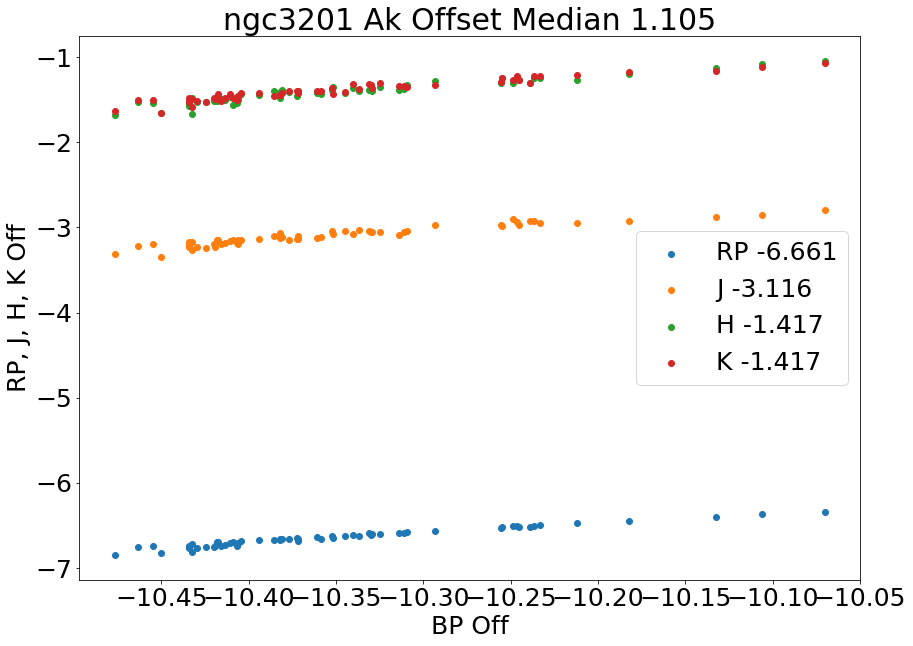

In [94]:
plt.figure(figsize=[14,10])
plt.scatter(bpngc3201ak,rpngc3201ak,label='RP {:.3f}'.format(np.median(rpngc3201ak)))
plt.scatter(bpngc3201ak,jngc3201ak,label='J {:.3f}'.format(np.median(jngc3201ak)))
plt.scatter(bpngc3201ak,hngc3201ak,label='H {:.3f}'.format(np.median(hngc3201ak)))
plt.scatter(bpngc3201ak,kngc3201ak,label='K {:.3f}'.format(np.median(kngc3201ak)))
plt.legend()
# plt.plot([-0.25,0.0],[-0.25,0.0],c='k')
plt.title(r'ngc3201 Ak Offset Median {:.3f}'.format(akshift))
plt.xlabel('BP Off')
plt.ylabel('RP, J, H, K Off')
plt.savefig('../plots/NGC3201AkModOff.pdf')
plt.show()

In [47]:
# clusakshift = np.array([-1.0,-0.5,-0.25,-0.01,0.0,0.01,0.25,0.5,1.0])
# abp_ak = ccm_alav(leff['BP'],3.1)/ccm_alav(leff['K'],3.1)
# arp_ak = ccm_alav(leff['RP'],3.1)/ccm_alav(leff['K'],3.1)
# aj_ak = ccm_alav(leff['J'],3.1)/ccm_alav(leff['K'],3.1)
# ah_ak = ccm_alav(leff['K'],3.1)/ccm_alav(leff['K'],3.1)

# allbpak = 999999.0*np.ones((len(gcs_clus),len(clusakshift)))
# allrpak = 999999.0*np.ones((len(gcs_clus),len(clusakshift)))
# alljak = 999999.0*np.ones((len(gcs_clus),len(clusakshift)))
# allhak = 999999.0*np.ones((len(gcs_clus),len(clusakshift)))
# allkak = 999999.0*np.ones((len(gcs_clus),len(clusakshift)))

# for i in tqdm_notebook(range(len(gcs_clus))):
#     # Pick Cluster
#     clus = np.where(gcs['CLUSTER'] == gcs_clus[i])
    
#     for j in range(len(clusakshift)):
#         # Select Isochrone To Create Synthetic Data
#         isopick = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9)))&
#                                    (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#         isopick = isopick[np.argsort(isopick['logTe'])]
        
#         # Create Synthetic Spectroscopy
#         synclusteff = np.random.normal(10**isopick['logTe'],np.nanmedian(gcsdr17['TEFF_ERR']),len(isopick))
#         synclusfeh = (np.random.normal(vanden_feh[i],np.nanmedian(gcsdr17['FE_H_ERR']),len(isopick)))
        
#         # Create Synthetic Photometry
#         synbpclus = 999999.0*np.ones(len(isopick))
#         synrpclus = 999999.0*np.ones(len(isopick))
#         synjclus = 999999.0*np.ones(len(isopick))
#         synhclus = 999999.0*np.ones(len(isopick))
#         synkclus = 999999.0*np.ones(len(isopick))
        
#         for k in range(len(isopick)):
#             bpmag = (np.random.normal(isopick['G_BPmag'][j],np.nanmedian(bperr))+5*np.log10(harris_dist[i])-5.0)
#             rpmag = (np.random.normal(isopick['G_RPmag'][j],np.nanmedian(rperr))+5*np.log10(harris_dist[i])-5.0)
#             jmag = (np.random.normal(isopick['Jmag'][j],np.nanmedian(gcsdr17['J_ERR']))+5*np.log10(harris_dist[i])-5.0)
#             hmag = (np.random.normal(isopick['Hmag'][j],np.nanmedian(gcsdr17['H_ERR']))+5*np.log10(harris_dist[i])-5.0)
#             kmag = (np.random.normal(isopick['Ksmag'][j],np.nanmedian(gcsdr17['K_ERR']))+5*np.log10(harris_dist[i])-5.0)

#             # BP magnitudes
#             if np.isfinite(bpmag)==True:
#                 synbpext[j] = bpmag+0.34*abp_ebv
#             else:
#                 synbpext[j] = 999999.0

#             # RP magnitudes
#             if np.isfinite(rpmag)==True:
#                 synrpext[j] = rpmag+0.34*arp_ebv
#             else:
#                 synrpext[j] = 999999.0

#             # J magnitudes
#             if np.isfinite(jmag)==True:
#                 synjext[j] = jmag+0.34*aj_ebv
#             else:
#                 synjext[j] = 999999.0

#             # H magnitudes
#             if np.isfinite(hmag)==True:
#                 synhext[j] = hmag+0.34*ah_ebv
#             else:
#                 synhext[j] = 999999.0

#             # K magnitudes
#             if np.isfinite(kmag)==True:
#                 synkext[j] = kmag+0.34*ak_ebv
#             else:
#                 synkext[j] = 999999.0
                
#         ### Get Individual Shifts
#         # Select isochrone to spline
#         isopick2 = massive[np.where((massive['logAge']==closest(massive['logAge'],np.log10(vanden_age[i]*10**9)))&
#                                     (massive['MH']==closest(massive['MH'],vanden_feh[i])))]
#         isopick2 = isopick2[np.argsort(isopick2['logTe'])]
        
#         # Splines For Interpolation
#         bp_spl = IUS(10**isopick2['logTe'][::2],isopick2['G_BPmag'][::2])
#         rp_spl = IUS(10**isopick2['logTe'][::2],isopick2['G_RPmag'][::2])
#         j_spl = IUS(10**isopick2['logTe'][::2],isopick2['Jmag'][::2])
#         h_spl = IUS(10**isopick2['logTe'][::2],isopick2['Hmag'][::2])
#         k_spl = IUS(10**isopick2['logTe'][::2],isopick2['Ksmag'][::2])
        
#         bpclusshift = bp_spl(synteff)-(synbpext-0.34*abp_ebv-clusakshift[j]*abp_ak-5*np.log10(harris_dist[i])+5.0)
#         rpclusshift = rp_spl(synteff)-(synrpext-0.34*arp_ebv-clusakshift[j]*arp_ak-5*np.log10(harris_dist[i])+5.0)
#         jclusshift = j_spl(synteff)-(synjext-0.34*aj_ebv-clusakshift[j]*aj_ak-5*np.log10(harris_dist[i])+5.0)
#         hclusshift = h_spl(synteff)-(synhext-0.34*ah_ebv-clusakshift[j]*ah_ak-5*np.log10(harris_dist[i])+5.0)
#         kclusshift = k_spl(synteff)-(synkext-0.34*ak_ebv-clusakshift[j]-5*np.log10(harris_dist[i])+5.0)
        
#         allbpak[i,j] = np.nanmedian(bpclusshift)
#         allrpak[i,j] = np.nanmedian(rpclusshift)
#         alljak[i,j] = np.nanmedian(jclusshift)
#         allhak[i,j] = np.nanmedian(hclusshift)
#         allkak[i,j] = np.nanmedian(kclusshift)

In [48]:
# aklabels = clusakshift.astype(str)
# plt.figure(figsize=[30,55])
# plt.suptitle(r'[Fe/H] Magnitude Offset With Synthetic Data',y=0.9)
# ###
# plt.subplot(511)
# for i in range(9):
#     plt.scatter(range(30),allbpak[:,i],label='{} mag'.format(aklabels[i]))
#     plt.plot(range(30),allbpak[:,i])
# plt.ylim(top=12)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('BP Offset')
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(512)
# for i in range(9):
#     plt.scatter(range(30),allrpak[:,i],label='{} mag'.format(aklabels[i]))
#     plt.plot(range(30),allrpak[:,i])
# plt.ylim(top=12)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('RP Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(513)
# for i in range(9):
#     plt.scatter(range(30),alljak[:,i],label='{} mag'.format(aklabels[i]))
#     plt.plot(range(30),alljak[:,i])
# plt.ylim(top=12)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('J Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(514)
# for i in range(9):
#     plt.scatter(range(30),allhak[:,i],label='{} mag'.format(aklabels[i]))
#     plt.plot(range(30),allhak[:,i])
# plt.ylim(top=12)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('H Offset') 
# plt.xticks(range(30),visible=False)
# plt.grid(True)

# ###
# plt.subplot(515)
# for i in range(9):
#     plt.scatter(range(30),allkak[:,i],label='{} mag'.format(aklabels[i]))
#     plt.plot(range(30),allkak[:,i])
# plt.ylim(top=12)    
# plt.legend(loc='upper right',ncol=6)
# plt.ylabel('K Offset')
# plt.xticks(range(30),labels=list(gcs_clus),rotation='vertical')
# plt.grid(True)
# plt.savefig('synclusakoff.pdf',bbox_iches='tight')
# plt.show()

derive own doistanmces using gaia
script for gaia clsuetsr 
radial cut 2-3 mas 

brifhtter stars get parallax directly
